=> loading checkpoint 'mamlfgsmeps2.pt'
=> loaded checkpoint 'mamlfgsmeps2.pt' (epoch 1)
=> loading checkpoint 'mamleps2.pt'
=> loaded checkpoint 'mamleps2.pt' (epoch 1)
shuffle DB :test, b:100, 5-way, 1-shot, 15-query, resize:84
Visualization of the input of the model (MAML) by maximizing neuron 200


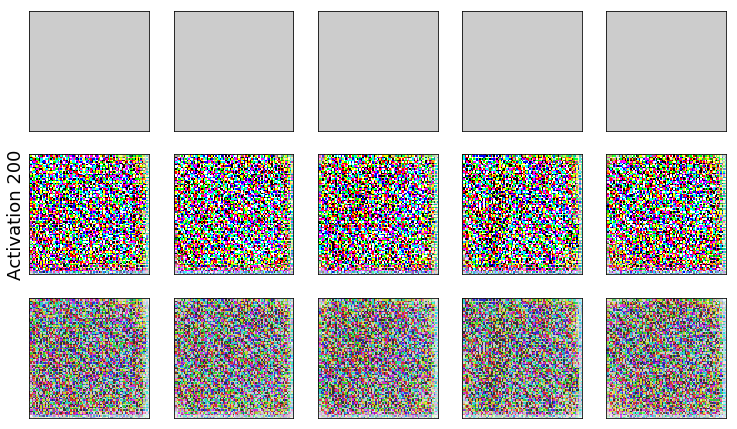

Visualization of the input of the model (MAML+FGSM-RS) by maximizing neuron 200


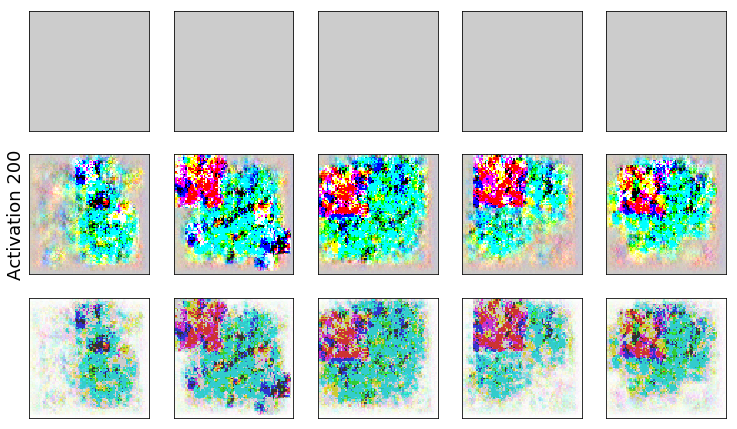

Visualization of the input of the fine-tuned model (MAML+FGSM-RS) by maximizing neuron 200


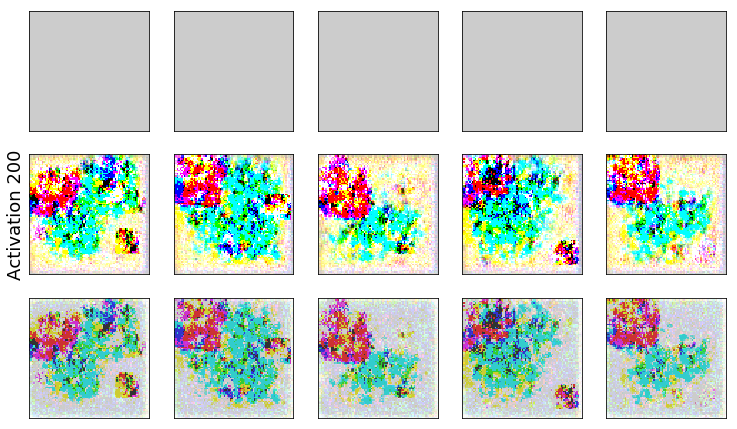

Visualization of the input of the model (MAML) by maximizing neuron 300


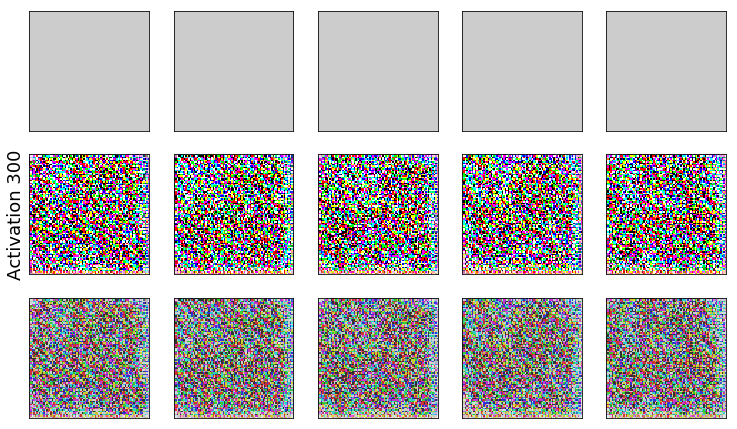

Visualization of the input of the model (MAML+FGSM-RS) by maximizing neuron 300


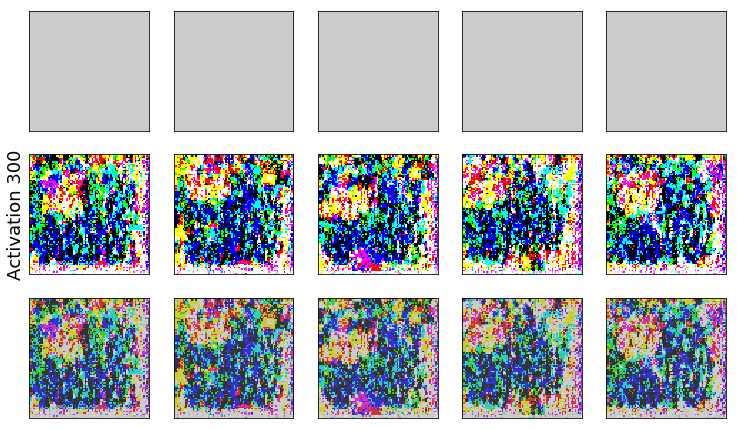

Visualization of the input of the fine-tuned model (MAML+FGSM-RS) by maximizing neuron 300


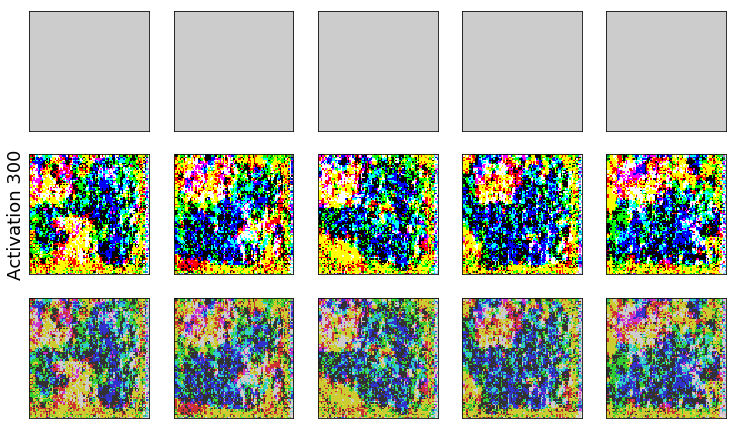

Visualization of the input of the model (MAML) by maximizing neuron 400


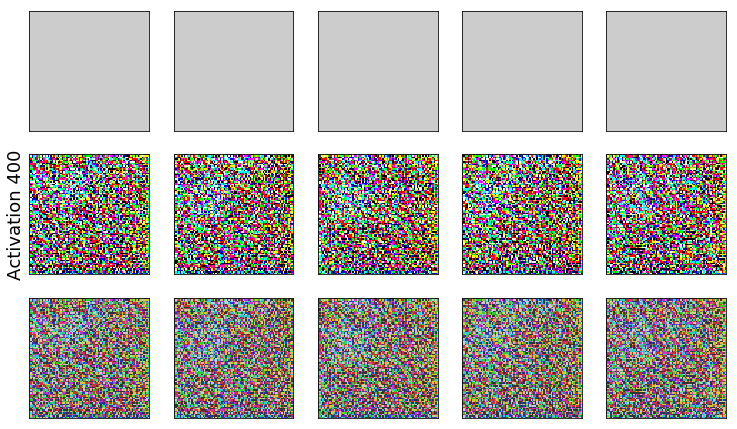

Visualization of the input of the model (MAML+FGSM-RS) by maximizing neuron 400


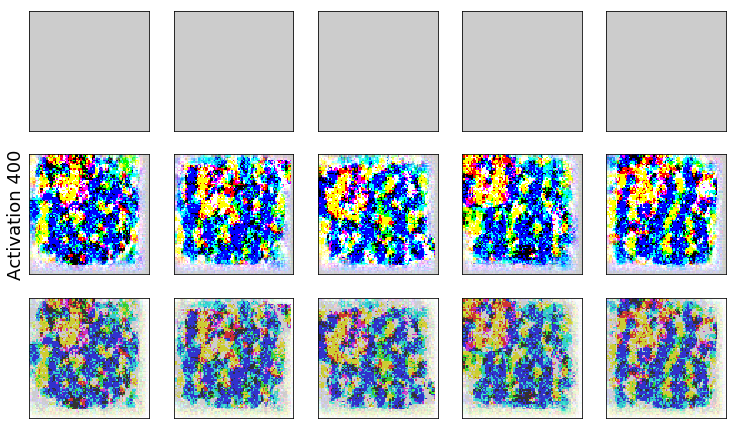

Visualization of the input of the fine-tuned model (MAML+FGSM-RS) by maximizing neuron 400


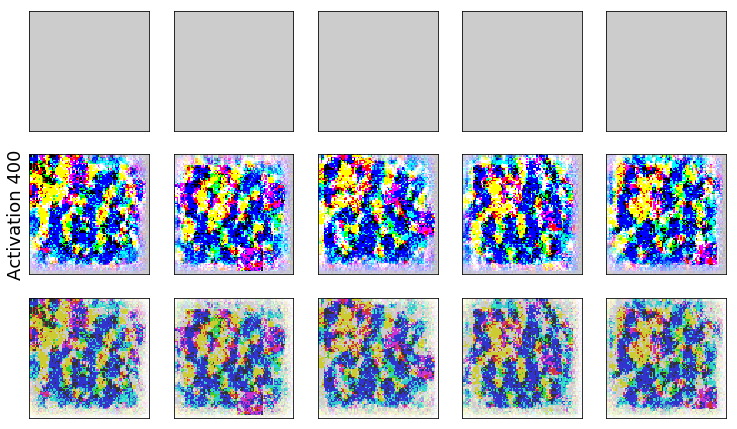

Visualization of the input of the model (MAML) by maximizing neuron 500


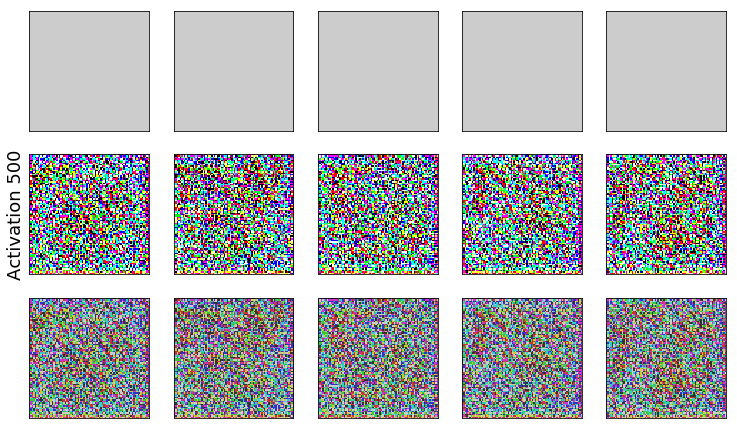

Visualization of the input of the model (MAML+FGSM-RS) by maximizing neuron 500


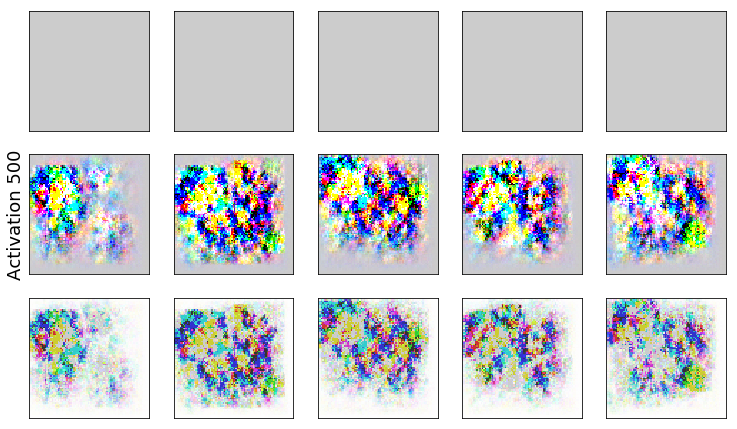

Visualization of the input of the fine-tuned model (MAML+FGSM-RS) by maximizing neuron 500


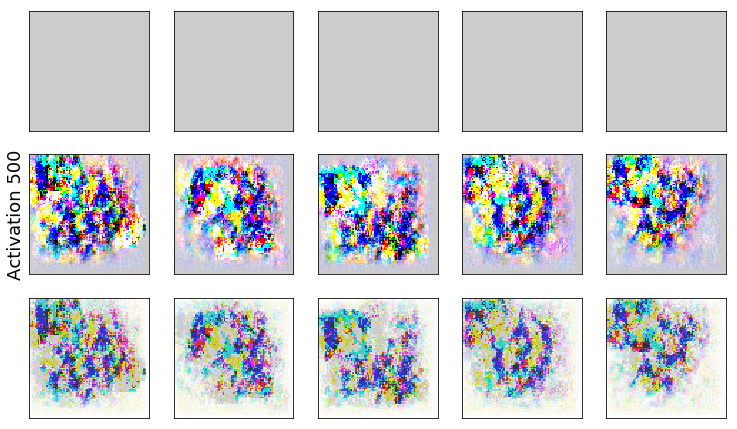

Visualization of the input of the model (MAML) by maximizing neuron 600


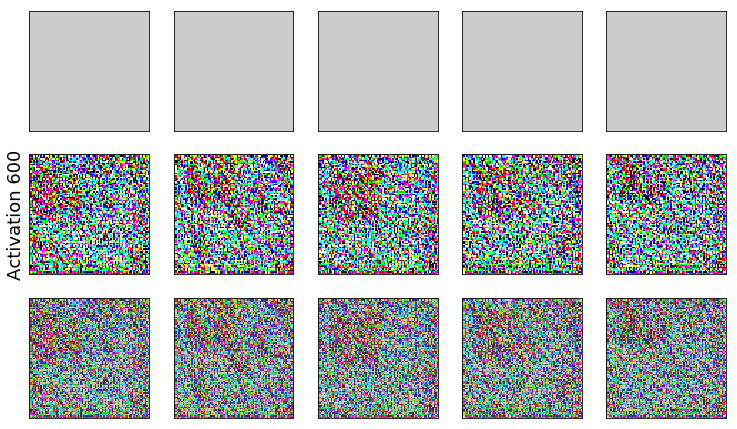

Visualization of the input of the model (MAML+FGSM-RS) by maximizing neuron 600


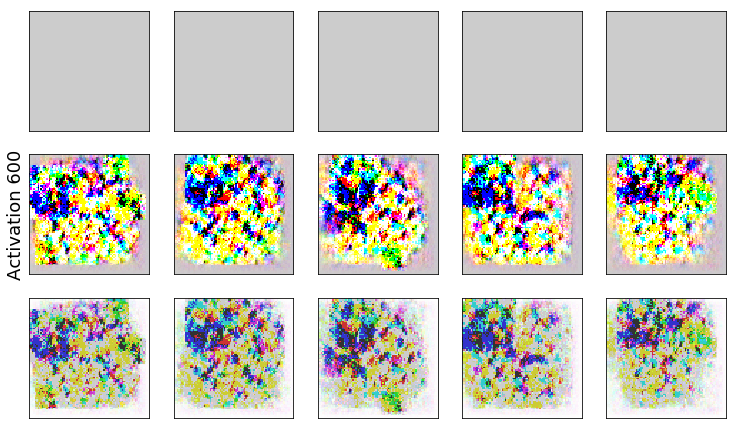

Visualization of the input of the fine-tuned model (MAML+FGSM-RS) by maximizing neuron 600


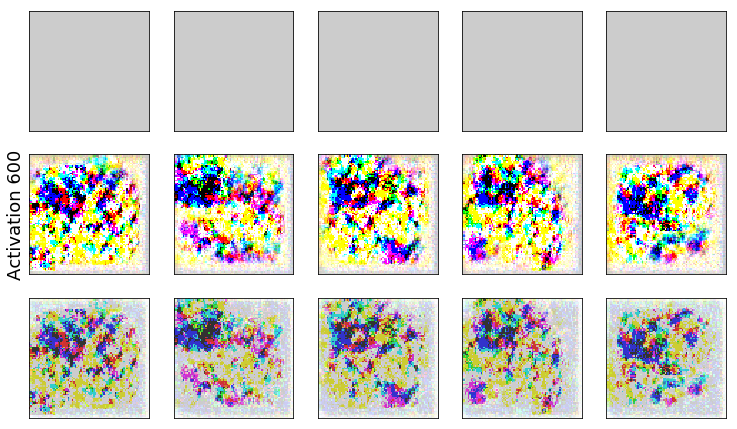

Visualization of the input of the model (MAML) by maximizing neuron 700


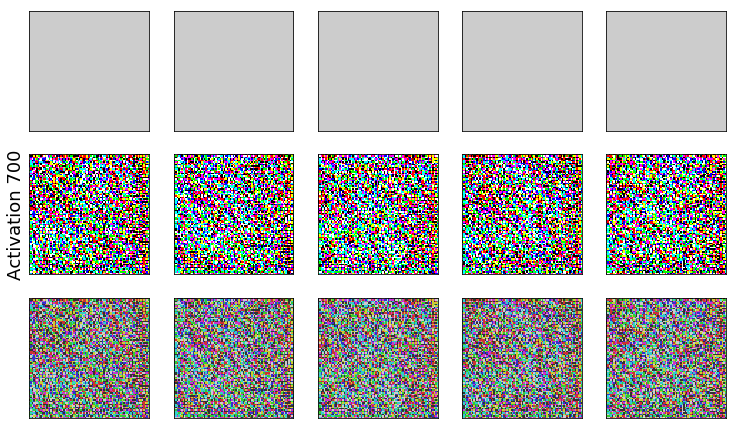

Visualization of the input of the model (MAML+FGSM-RS) by maximizing neuron 700


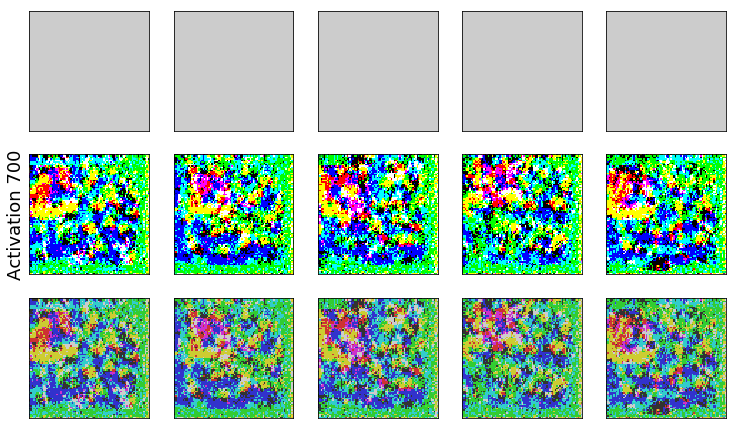

Visualization of the input of the fine-tuned model (MAML+FGSM-RS) by maximizing neuron 700


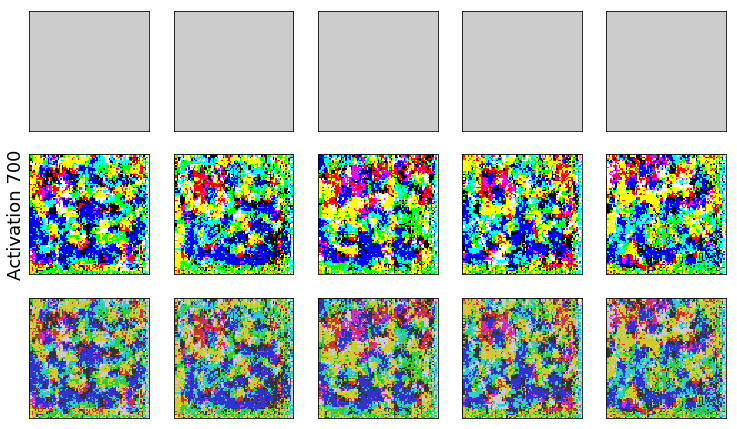

In [1]:
import  torch, os
import  numpy as np
from    MiniImagenet import MiniImagenet
import  scipy.stats
from    torch.utils.data import DataLoader
from    torch.optim import lr_scheduler
import  random, sys, pickle
import  argparse
import time

from MODELMETA import Meta
from Visualization import RobustVis
from vis_tool import show_image_row, show_image_column

def main():

    torch.manual_seed(222)
    torch.cuda.manual_seed_all(222)
    np.random.seed(222)

    config = [
        ('conv2d', [32, 3, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 1, 0]),
        ('flatten', []),
        ('linear', [args.n_way, 32 * 5 * 5])
    ]

    device = torch.device('cuda:3')
    maml_robust = Meta(args, config, device).to(device)
    maml_standard = Meta(args, config, device).to(device)

    start_epoch = 0
    start_step = 0
    filename = 'mamlfgsmeps2.pt'
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        start_step = checkpoint['step']
        maml_robust.net.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))
        
        
    filename = 'mamleps2.pt'
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        start_step = checkpoint['step']
        maml_standard.net.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    mini_test = MiniImagenet('../../../dataset/', mode='test', n_way=args.n_way, k_shot=args.k_spt,
                             k_query=args.k_qry,
                             batchsz=100, resize=args.imgsz)


    db = DataLoader(mini_test,  1, shuffle=True, num_workers=0, pin_memory=True)

    for step, (x_spt1, y_spt1, x_qry1, y_qry1) in enumerate(db):
        if step == 0:
            x_spt, y_spt, x_qry, y_qry = x_spt1.squeeze(0).to(device), y_spt1.squeeze(0).to(device), \
                                                 x_qry1.squeeze(0).to(device), y_qry1.squeeze(0).to(device)
#             x_s = x_spt.view(-1, 3, 84, 84)
#             x_s = 0.2 * torch.ones(5,3,84,84)
#             kwargs = {
#                 'criterion': torch.nn.CrossEntropyLoss(),
#                 'custom_loss': None,
#                 'constraint':'inf',
#                 'eps': 1,
#                 'step_size': 0.1,
#                 'iterations': 1000, 
#                 'targeted': False,
#             }
#             robustv = RobustVis(maml.net, device)
#             for max_ind in range(1):
#                 loss, x_p = robustv.forward(x_s.to(device), max_ind, **kwargs)
#                 show_image_row([x_p.detach().cpu()], [f'Activation {max_ind}'], fontsize=18, baseline=[x_s.detach().cpu()])
        else:
            break


    x_s = 0.2 * torch.ones(5,3,84,84)
    kwargs = {
        'criterion': torch.nn.CrossEntropyLoss(),
        'custom_loss': None,
        'constraint':'inf',
        'eps': 1,
        'step_size': 0.1,
        'iterations': 1000, 
        'targeted': False,
    }
    robustv = RobustVis(maml_robust.net, device)
    standv = RobustVis(maml_standard.net, device)
    for max_ind in range(200,800,100):
        print('Visualization of the input of the model (MAML) by maximizing neuron {}'.format(max_ind))
        loss, x_p_st = standv.forward(x_s.to(device), max_ind, **kwargs)
        show_image_row([x_p_st.detach().cpu()], [f'Activation {max_ind}'], fontsize=18, baseline=[x_s.detach().cpu()])
        print('Visualization of the input of the model (MAML+FGSM-RS) by maximizing neuron {}'.format(max_ind))
        loss, x_p = robustv.forward(x_s.to(device), max_ind, **kwargs)
        show_image_row([x_p.detach().cpu()], [f'Activation {max_ind}'], fontsize=18, baseline=[x_s.detach().cpu()])
        print('Visualization of the input of the fine-tuned model (MAML+FGSM-RS) by maximizing neuron {}'.format(max_ind))
        loss, x_p_ft = maml_robust.finetunning(x_spt, y_spt, x_qry, y_qry, x_s, max_ind, kwargs)
        show_image_row([x_p_ft.detach().cpu()], [f'Activation {max_ind}'], fontsize=18, baseline=[x_s.detach().cpu()])
                
                


if __name__ == '__main__':

    argparser = argparse.ArgumentParser()
    argparser.add_argument('--epoch', type=int, help='epoch number', default=10000)
    argparser.add_argument('--n_way', type=int, help='n way', default=5)
    argparser.add_argument('--k_spt', type=int, help='k shot for support set', default=1)
    argparser.add_argument('--k_qry', type=int, help='k shot for query set', default=15)
    argparser.add_argument('--imgsz', type=int, help='imgsz', default=84)
    argparser.add_argument('--imgc', type=int, help='imgc', default=3)
    argparser.add_argument('--task_num', type=int, help='meta batch size, namely task num', default=4)
    argparser.add_argument('--meta_lr', type=float, help='meta-level outer learning rate', default=1e-3)
    argparser.add_argument('--update_lr', type=float, help='task-level inner update learning rate', default=0.01)
    argparser.add_argument('--update_step', type=int, help='task-level inner update steps', default=5)
    argparser.add_argument('--update_step_test', type=int, help='update steps for finetunning', default=10)
    
    #argparser.add_argument('--fast', action="store_true", help='whether to use fgsm')

    args = argparser.parse_args(args=[])

    main()